 # Lab:  Transfer Learning with a Pre-Trained Deep Neural Network

As we discussed earlier, state-of-the-art neural networks involve millions of parameters that are prohibitively difficult to train from scratch.  In this lab, we will illustrate a powerful technique called *transfer learning*, where we start with a large pre-trained network and then re-train only the final layers to adapt it to a new task.  The method is also called *fine-tuning* and can produce excellent results on very small datasets with very little computational time.  

This lab is based partially on this
[excellent blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), althought the details there are for Keras, not PyTorch.  In performing this lab, you will learn to:
* Build a custom image dataset
* Fine tune the final layers of an existing deep neural network for a new classification task.

You may run the lab on a CPU machine (like a laptop) or a GPU.  The GPU training is much faster (< 1 minute).  But even the CPU training time should be < 20 minutes.

## Create a Dataset

In this lab, we will train a network to discriminate between two classes:  `cars` and `bicycles`.  One could imagine that this type of network could be useful in vehicle vision systems.   The first task is to build a dataset.  For this, please follow the directions in [demo_cnn_flickr](../Demos/demo_cnn_flickr.ipynb)  

TODO:  Create training and test directories with:
* 1000 training images of cars
* 1000 training images of bicylces
* 300 test images of cars
* 300 test images of bicycles
* The images don't need to be the same size.

The images should be organized in the following directory structure:

    ./train
        /car
           car_0000.jpg
           car_0001.jpg
           ...
           car_0999.jpg
        /bicycle
           bicycle_0000.jpg
           bicycle_0001.jpg
           ...
           bicycle_0999.jpg
    ./test
        /car
           car_0000.jpg
           car_0001.jpg
           ...
           car_0299.jpg
        /bicycle
           bicycle_0000.jpg
           bicycle_0001.jpg
           ...
           bicycle_0299.jpg
                

Now we'll select the image dimensions for our neural network.  They need not be the same as those of the downloaded images, or even the 224x224 size that the network was optimized for, but they should be small enough to work on your machine without taking forever.  If you have a CPU machine, a good choice is 64 x 64. But if you have a GPU image, then you can use a larger image size, like 150 x 150.

In [1]:
nrow = 224
ncol = 224

## Using the DataLoader with ImageFolder

We will now create an `ImageFolder` object, like in the VGG demo of this unit.
As we did in that demo, we will use a `torchvision.transform` to preprocess the data when training our network.
The steps are as follows.

Using `transforms.Compose`, first create a `data_transform` that
1) randomly crops a section of between 0.5 and 1 of the original image's size, and then resizes it to `nrow` x `ncol` pixels,
2) converts to a `Torch.Tensor`,
3) normalizes using the standard ImageNet scalings.

Apply that transform to the data in `./train` using `ImageFolder`, and call the output `train_ds`.

Give `train_ds` and the batch size to `DataLoader`, and call the output `train_dl`.  Don't forget to shuffle. 

In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

batch_size = 64
# Create training data loader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_ds = ImageFolder(root='./train', transform=transform)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

Now, create a `test_dl` object for the test data, using the same transform as for the training data.

In [3]:
# Create test data loader similar to above

# TODO
test_ds = ImageFolder(root='./test', transform=transform)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

The following image display function will be useful later.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### Code from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html #####
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # rearrange dimensions from (color,y,x) -> (y,x,color)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # undo the normalization
    inp = np.clip(inp, 0, 1)
    # Display image, without ticks
    plt.imshow(inp)
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title)

###########################################################################################

To see how the `train_dl` works, use the `next(iter(train_dl))` method to get a minibatch of data `X,y`.  Display the first 8 images in this mini-batch and label the image with its class label.  You should see that bicycles have `y=0` and cars have `y=1`.

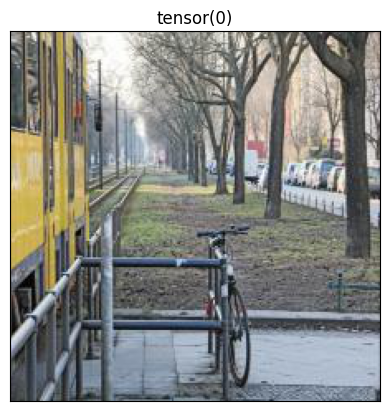

In [5]:
# TODO
X,y = next(iter(train_dl))
imshow(X[0], y[0])

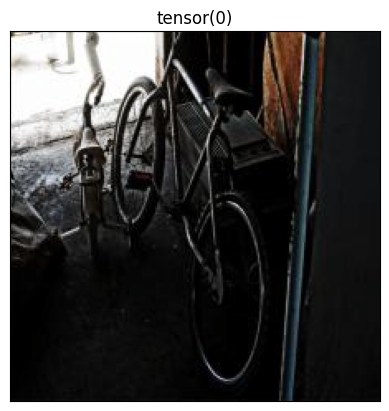

In [6]:
imshow(X[1], y[1])

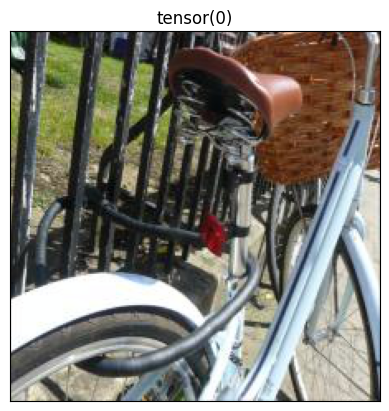

In [7]:
imshow(X[2], y[2])

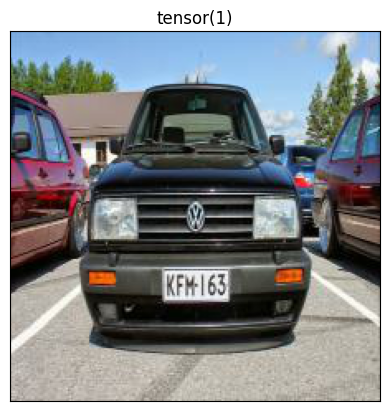

In [8]:
imshow(X[3], y[3])

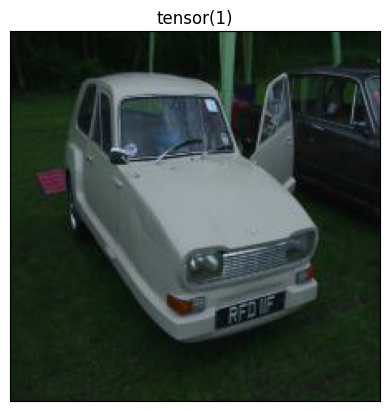

In [9]:
imshow(X[4], y[4])

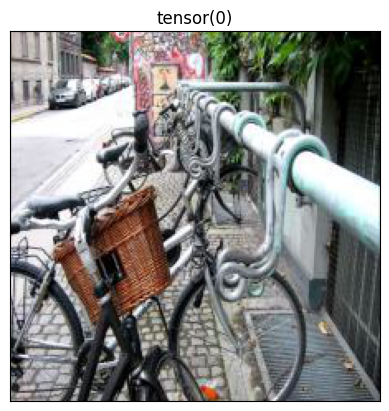

In [10]:
imshow(X[5], y[5])

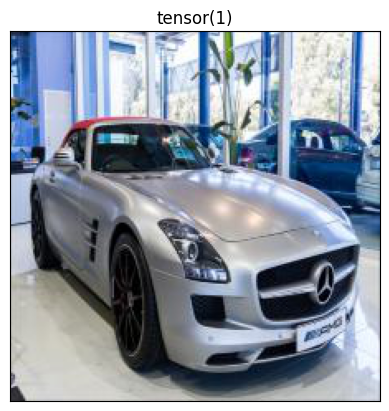

In [11]:
imshow(X[6], y[6])

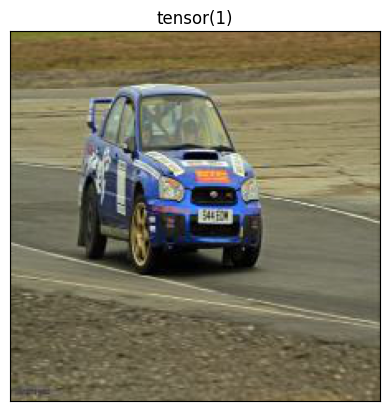

In [12]:
imshow(X[7], y[7])

## Loading a Pre-Trained Deep Network

Follow the VGG16 demo to load a pre-trained VGG16 network.  Rember to set `pretrained=True` in order to also load the pre-trained weights.

In [13]:
import torch
from torchvision.models import vgg16

# TODO:  Load the VGG16 network
model = vgg16(pretrained=True)

D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now, freeze the parameters of the pretrained model.  To do this, loop over the parameters in the model and set their `requires_grad` flag to `False`. This will stop PyTorch from calculating the gradient for those parameters and stop them from being updated by the optimizer.

In [14]:
# TODO freeze layers
for i in enumerate(model.parameters()):
    model.requires_grad_ = False

Remember, from the VGG16 demo, that the network has a `features` portion, with convolutional layers, and a `classifier` portion, with fully connected layers.  We will keeping the features portion but replace the classifier portion.  The idea is that the features portion, which was trained on all of ImageNet, will generate useful features for any image classification task, such as differentiating cars and bikes.

In order to replace the classifier portion, we first need to find the size of the input to the classifier portion of the network, so that we can build our own with the proper size.  You can do this using

In [15]:
print(model.classifier[0])

Linear(in_features=25088, out_features=4096, bias=True)


Replace `model.classifier` with a neural network consisting of the following layers:
* Linear w/ 256 output channels
* ReLU
* Dropout w/ p = 0.5
* Linear w/ 1 output channel (indicating car vs bike)
* Sigmoid

This network can be constructed using 1 line via `nn.Sequential`.

In [16]:
import torch.nn as nn

# TODO Replace the classifier part of the network
model.classifier = nn.Sequential(nn.Linear(25088, 256),
                                nn.ReLU(inplace=True),
                                nn.Dropout(0.5),
                                nn.Linear(256, 1),
                                nn.Sigmoid())

Now we will print a summary of the model.
Confirm that it includes a features portion and a classifier portion, each constructed by a Sequential() object.
The features portion should be the same as the VGG network, and the classifier portion should consist of the following sequence of Modules: Linear, Relu, Dropout, Linear, Sigmoid.

In [17]:
print(str(model))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Train the Model

Select the correct loss function and an optimizer to train the model. 

**Remember that we are doing *binary* classification here, so do not blindly copy-and-paste code from the VGG demo (on non-binary classification) and expect it to work here!**

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
!nvidia-smi

Using cuda device
Fri Nov 17 23:53:16 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.42                 Driver Version: 537.42       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P0              17W / 140W |      0MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------

In [19]:
import torch.optim as optim

lr = 1e-3

# TODO
model.eval()
model = model.to(device)
criterion = nn.BCELoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)

Now, run the training.  If you are using a CPU on a regular laptop, each epoch should take about 1-4 minutes, so you should be able to finish 5 epochs or so within 5-20 minutes.  On a reasonable GPU, even with 150 x 150 images, it should take about 10 seconds per epoch.  If you use `(nrow,ncol) = (64,64)` images, you should get about 95% accuracy after 5 epochs (although it may be a bit higher or lower).

In [20]:
# TODO
num_epoch = 5

a_tr_loss = np.zeros([num_epoch])
a_tr_accuracy = np.zeros([num_epoch])
a_ts_loss = np.zeros([num_epoch])
a_ts_accuracy = np.zeros([num_epoch])

for epoch in range(num_epoch):

    model.train() # put model in training mode
    correct = 0 # initialize error counter
    total = 0 # initialize total counter
    batch_loss_tr = []
    # iterate over training set
    for train_iter, data in enumerate(train_dl):
        x_batch,y_batch = data
        x_batch,y_batch = x_batch.to(device), y_batch.to(device)
        y_batch = y_batch.type(torch.float)
        out = model(x_batch)
        # Compute Loss
        out = out.reshape(64)
        loss = criterion(out,y_batch)
        batch_loss_tr.append(loss.item())
        # Compute gradients using back propagation
        opt.zero_grad()
        loss.backward()
        # Take an optimization 'step'
        opt.step()
        # Do hard classification: index of largest score
        _, predicted = torch.max(out.data, 1)
        # Compute number of decision errors
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        
    a_tr_loss[epoch] = np.mean(batch_loss_tr) # Compute average loss over epoch
    a_tr_accuracy[epoch] = 100*correct/total

    model.eval() # put model in evaluation mode
    correct = 0 # initialize error counter
    total = 0 # initialize total counter
    batch_loss_ts = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            labels = labels.type(torch.long)
            outputs = model(images)
            outputs = outputs.reshape(64)
            batch_loss_ts.append(criterion(outputs,labels).item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    a_ts_loss[epoch] = np.mean(batch_loss_ts)
    a_ts_accuracy[epoch] = 100*correct/total
    # Print details every print_mod epoch
    print('Epoch: {0:2d}   Train Loss: {1:.3f}   '.format(epoch+1, a_tr_loss[epoch])
          +'Train Acc: {0:.2f}    Test Loss: {1:.3f}   '.format(a_tr_accuracy[epoch], a_ts_loss[epoch])
          +'Test Acc: {0:.2f}'.format(a_ts_accuracy[epoch]))

RuntimeError: shape '[64]' is invalid for input of size 16

Finally, show some example test images with their predicted and actual labels in the title.

In [ ]:
n_show = 8
# TODO
